# Julia is Fast - `@time`, `@elapsed` and `@inbounds`

---

In this notebook, we demonstrate how fast `Julia` is, compared to other dynamically typed languages. 

## Prerequisites

Read the text [Why Julia?](https://github.com/stevengj/julia-mit/blob/master/README.md#why-julia) (3 min)

Read [Performance tips](https://docs.julialang.org/en/stable/manual/performance-tips/) section of the `Julia` manual. (20 min) 

## Competences 

The reader should understand effects of "[just-in-time
compiler](https://en.wikipedia.org/wiki/Just-in-time_compilation)"
called [LLVM](http://llvm.org/) on the speed of execution of programs. 
The reader should be able to write simple, but fast, programs containing loops.

## Credits 

Some examples are taken from [The Julia Manual](https://docs.julialang.org/en/stable/).


## Scholarly example - summing integer halves

Consider the function `f` which sums halves of integers from `1` to `n`:

__N.B.__ `Esc l` toggles line numbers in the current cell.

In [1]:
function f(n)
    s = 0
    for i = 1:n
        s += i/2
    end
    s
end

f (generic function with 1 method)

In order for the fast execution, the function must first be compiled. Compilation is performed automatically, when the function is invoked for the first time. Therefore, the first call can be done with some trivial choice of parameters.

The timing can be done by two commands, `@time` and `@elapsed`: 

In [2]:
?@time

```
@time
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression.

See also [`@timev`](@ref), [`@timed`](@ref), [`@elapsed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> @time rand(10^6);
  0.001525 seconds (7 allocations: 7.630 MiB)

julia> @time begin
           sleep(0.3)
           1+1
       end
  0.301395 seconds (8 allocations: 336 bytes)
```


In [3]:
?@elapsed

```
@elapsed
```

A macro to evaluate an expression, discarding the resulting value, instead returning the number of seconds it took to execute as a floating-point number.

See also [`@time`](@ref), [`@timev`](@ref), [`@timed`](@ref), and [`@allocated`](@ref).

```julia-repl
julia> @elapsed sleep(0.3)
0.301391426
```


In [4]:
@time f(1) 

  0.031621 seconds (1.71 k allocations: 92.409 KiB)


0.5

In [5]:
# This run is much faster, since the function is already compiled
@elapsed f(1)

4.47e-6

Let us now run the big-size computation. Notice the unnaturally high byte allocation and the huge amount of time spent on 
[garbage collection](http://en.wikipedia.org/wiki/Garbage_collection_%28computer_science%29).

In [6]:
# Notice the unnaturally high byte  allocation!
@time f(1000000)

  0.108643 seconds (3.00 M allocations: 45.777 MiB, 46.71% gc time)


2.5000025e11

In [7]:
# We shall be using @time from now on
@elapsed f(1000000)

0.045747749

Since your computer can execute several _Gigaflops_ (floating-point operations per second), this is rather slow. This slowness is due to _type instability_: variable `s` is in the beginning assumed to be of type `Integer`, while at every other step, the result is a real number of type `Float64`. Permanent checking of types requires permanent memory allocation and deallocation (garbage collection). This is corrected by very simple means: just declare `s` as a real number, and the execution is more than 10 times faster with almost no memory allocation (and, consequently, no garbage collection).

In [8]:
function f1(n)
    s = 0.0
    for i = 1:n
        s += i/2
    end
    s
end

f1 (generic function with 1 method)

In [9]:
@time f1(1)

  0.016897 seconds (1.10 k allocations: 58.366 KiB)


0.5

In [10]:
@time f1(1000000)

  0.001064 seconds (5 allocations: 176 bytes)


2.5000025e11

`@time` can alo be invoked as a function:

In [11]:
@time(f1(1000000))

  0.001137 seconds (5 allocations: 176 bytes)


2.5000025e11

In [12]:
@time s2=f1(1000000)

  0.001065 seconds (6 allocations: 224 bytes)


2.5000025e11

In [13]:
@time(s2=f1(1000000))

  0.001091 seconds (5 allocations: 176 bytes)


2.5000025e11

## Real-world example - exponential moving average

[Exponential moving average](http://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) is a fast _one pass_ formula (each data point of the given data set $A$ is accessed only once) often used in high-frequency on-line trading (see [Online Algorithms in High-Frequency Trading](http://cacm.acm.org/magazines/2013/10/168184-online-algorithms-in-high-frequency-trading/fulltext) for more details). __Notice that the output array $X$ is declared in advance.__

Using `return` in the last line is here optional.


In [14]:
function fexpma{T}( A::Vector{T}, α::T )
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array{T}(n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end


fexpma (generic function with 1 method)

In [15]:
# First run for compilation
fexpma([1.0],0.5)

1-element Array{Float64,1}:
 1.0

We now generate some big-size data:

In [16]:
# Big random slightly increasing sequence
A=[rand() + 0.00001*k*rand() for k=1:20_000_000]

20000000-element Array{Float64,1}:
   0.637048
   0.216254
   0.672529
   0.801822
   0.51794 
   0.538427
   0.531375
   0.104075
   0.875322
   0.587945
   0.971954
   0.510047
   0.413579
   ⋮       
  70.3381  
  69.5518  
 126.375   
  18.9786  
   7.16643 
  14.6474  
  52.1081  
 165.891   
  16.7126  
 105.642   
   2.65284 
 167.777   

In [17]:
@time X=fexpma(A,0.9)

  0.360626 seconds (7 allocations: 152.588 MiB, 47.00% gc time)


20000000-element Array{Float64,1}:
   0.637048
   0.594968
   0.602724
   0.622634
   0.612165
   0.604791
   0.597449
   0.548112
   0.580833
   0.581544
   0.620585
   0.609531
   0.589936
   ⋮       
 112.381   
 108.098   
 109.926   
 100.831   
  91.4644  
  83.7827  
  80.6153  
  89.1429  
  81.8998  
  84.2741  
  76.1119  
  85.2784  

## `@inbounds`

The `@inbounds` command eliminates array bounds checking within expressions. Be certain before doing this. If the subscripts are ever out of bounds, you may suffer crashes or silent corruption. The following program runs a little faster:

In [18]:
function fexpma{T}( A::Vector{T}, α::T )
# fast exponential moving average: X - moving average, 
# A - data, alpha - exponential forgetting parameter
    n = length(A)
    X = Array{T}(n) # Declare X
    β = one(T)-α
    X[1] = A[1]
    @inbounds for k = 2:n
        X[k] = β*A[k] + α*X[k-1]
    end
    return X
end

fexpma (generic function with 1 method)

In [19]:
@time X=fexpma(A,0.9)

  0.346716 seconds (2.06 k allocations: 152.696 MiB, 36.88% gc time)


20000000-element Array{Float64,1}:
   0.637048
   0.594968
   0.602724
   0.622634
   0.612165
   0.604791
   0.597449
   0.548112
   0.580833
   0.581544
   0.620585
   0.609531
   0.589936
   ⋮       
 112.381   
 108.098   
 109.926   
 100.831   
  91.4644  
  83.7827  
  80.6153  
  89.1429  
  81.8998  
  84.2741  
  76.1119  
  85.2784  

Similar `Matlab` programs give the following timing for the two versions of the function, first _without_ prior declaration of $X$ and then _with_ prior declaration. The _latter_ version is nine times faster. 

---
```
function X = fexpma0( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> A=rand(20000000,1)+0.00001*[1:20000000]'.*rand(20000000,1);
>> tic, X=fexpma0(A,0.9); toc
Elapsed time is 3.073359 seconds.
```

---

```
function X = fexpma( A,alpha )
% fast exponential moving average: X - moving average, A - data, alpha - exponential forgetting parameter
n=length(A);
X=zeros(n,1); % Allocate X in advance
beta=1-alpha;
X(1)=A(1);
for k=2:n
    X(k)=beta*A(k)+alpha*X(k-1);
end
```
```
>> tic, X=fexpma(A,0.9); toc
Elapsed time is 0.320976 seconds.
```

## Plotting the moving average

Let us plot the data $A$ and its exponential moving average $X$. The dimension of the data is too large for meaningful direct plot. In `Julia` we can use `@manipulate` command to slide through the data. It takes a while to read packages `Winston` (for plotting) and `Interact`, but this is needed only for the first invocation.

In [21]:
using Winston
using Interact

Interact.Options{:SelectionSlider,Int64}(1: "input" = 9999001 Int64 , "k", 9999001, "9999001", 10000, Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"1001"=>1001,"2001"=>2001,"3001"=>3001,"4001"=>4001,"5001"=>5001,"6001"=>6001,"7001"=>7001,"8001"=>8001,"9001"=>9001…), Dict(3454001=>"3454001",12015001=>"12015001",18813001=>"18813001",447001=>"447001",39001=>"39001",6157001=>"6157001",5292001=>"5292001",3713001=>"3713001",12507001=>"12507001",14797001=>"14797001"…)), Any[], Any[], true, "horizontal", true)

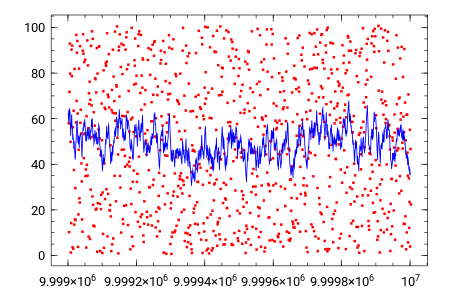

In [22]:
@manipulate for k=1:1000:20000000
    plot(collect(k:k+1000),A[k:k+1000],"r.",
        collect(k:k+1000),X[k:k+1000],"b")
end

### Remark
More details about optimizing your programs are given in the [Profiling Notebook](http://localhost:8890/notebooks/Documents/Julia/Julia-Course/src/05%20Profiling.ipynb).

## Pre-allocating output

The following example is from [Pre-allocating outputs](https://docs.julialang.org/en/stable/manual/performance-tips/#Pre-allocating-outputs-1). The functions `loopinc()` and `loopinc_prealloc()` both compute $\sum_{i=2}^{10000001}i$, the second one being 15 times faster: 

In [23]:
function xinc(x)
    return [x, x+1, x+2]
end

function loopinc()
    y = 0
    for i = 1:10^7
        ret = xinc(i)
        y += ret[2]
    end
    y
end

function xinc!{T}(ret::AbstractVector{T}, x::T)
    ret[1] = x
    ret[2] = x+1
    ret[3] = x+2
    nothing
end

function loopinc_prealloc()
    ret = Array{Int}(3)
    y = 0
    for i = 1:10^7
        xinc!(ret, i)
        y += ret[2]
    end
    y
end

loopinc_prealloc (generic function with 1 method)

In [24]:
@time loopinc()

  1.424986 seconds (40.00 M allocations: 1.490 GiB, 24.93% gc time)


50000015000000

In [26]:
@time loopinc_prealloc() # After the second run

  0.039859 seconds (6 allocations: 288 bytes)


50000015000000

## Memory access

The following example is from [Access arrays in memory order, along columns](https://docs.julialang.org/en/stable/manual/performance-tips/#Access-arrays-in-memory-order,-along-columns-1).

Multidimensional arrays in Julia are stored in column-major order, which means that arrays are stacked one column at a time. This convention for ordering arrays is common in many languages like Fortran, Matlab, and R (to name a few). The alternative to column-major ordering is row-major ordering, which is the convention adopted by C and Python (numpy) among other languages. The ordering can be verified using the `vec()` function or the syntax `[:]`:

In [27]:
B = rand(0:9,4,3)

4×3 Array{Int64,2}:
 0  8  9
 4  2  6
 3  2  0
 0  2  9

In [28]:
B[:]

12-element Array{Int64,1}:
 0
 4
 3
 0
 8
 2
 2
 2
 9
 6
 0
 9

In [29]:
vec(B)

12-element Array{Int64,1}:
 0
 4
 3
 0
 8
 2
 2
 2
 9
 6
 0
 9

The ordering of arrays can have significant performance effects when looping over arrays. Loops should be organized such that the subsequent accessed elements are close to each other in physical memory.

The following functions accept a `Vector` and and return a square `Array` with the rows or the columns filled with copies of the input vector, respectively.

In [30]:
function copy_cols{T}(x::Vector{T})
    n = size(x, 1)
    out = Array{eltype(x)}(n, n)
    for i=1:n
        out[:, i] = x
    end
    out
end

function copy_rows{T}(x::Vector{T})
    n = size(x, 1)
    out = Array{eltype(x)}(n, n)
    for i=1:n
        out[i, :] = x
    end
    out
end

copy_rows (generic function with 1 method)

In [31]:
copy_cols([1.0,2])
copy_rows([1.0,2])

2×2 Array{Float64,2}:
 1.0  2.0
 1.0  2.0

In [32]:
x=rand(5000) # generate a random vector

5000-element Array{Float64,1}:
 0.036955 
 0.950652 
 0.604693 
 0.707791 
 0.860578 
 0.902264 
 0.243147 
 0.143855 
 0.79275  
 0.747119 
 0.0966688
 0.593104 
 0.94554  
 ⋮        
 0.614552 
 0.883566 
 0.287877 
 0.384452 
 0.0114223
 0.479754 
 0.795568 
 0.711421 
 0.391847 
 0.166177 
 0.230773 
 0.723244 

In [33]:
@time C=copy_cols(x)  # We generate a large matrix

  0.259113 seconds (9.50 k allocations: 190.880 MiB, 4.74% gc time)


5000×5000 Array{Float64,2}:
 0.036955   0.036955   0.036955   …  0.036955   0.036955   0.036955 
 0.950652   0.950652   0.950652      0.950652   0.950652   0.950652 
 0.604693   0.604693   0.604693      0.604693   0.604693   0.604693 
 0.707791   0.707791   0.707791      0.707791   0.707791   0.707791 
 0.860578   0.860578   0.860578      0.860578   0.860578   0.860578 
 0.902264   0.902264   0.902264   …  0.902264   0.902264   0.902264 
 0.243147   0.243147   0.243147      0.243147   0.243147   0.243147 
 0.143855   0.143855   0.143855      0.143855   0.143855   0.143855 
 0.79275    0.79275    0.79275       0.79275    0.79275    0.79275  
 0.747119   0.747119   0.747119      0.747119   0.747119   0.747119 
 0.0966688  0.0966688  0.0966688  …  0.0966688  0.0966688  0.0966688
 0.593104   0.593104   0.593104      0.593104   0.593104   0.593104 
 0.94554    0.94554    0.94554       0.94554    0.94554    0.94554  
 ⋮                                ⋱                                 
 0.614

In [34]:
@time D=copy_rows(x); # This is few times slower

  0.364697 seconds (9.50 k allocations: 190.880 MiB, 18.67% gc time)


### Remark
There is also a built-in function `repmat()`:

In [35]:
?repmat

search: repmat



```
repmat(A, m::Integer, n::Integer=1)
```

Construct a matrix by repeating the given matrix (or vector) `m` times in dimension 1 and `n` times in dimension 2.

# Examples

```jldoctest
julia> repmat([1, 2, 3], 2)
6-element Array{Int64,1}:
 1
 2
 3
 1
 2
 3

julia> repmat([1, 2, 3], 2, 3)
6×3 Array{Int64,2}:
 1  1  1
 2  2  2
 3  3  3
 1  1  1
 2  2  2
 3  3  3
```


In [36]:
@time C1=repmat(x,1,5000);

  0.359771 seconds (31.25 k allocations: 192.110 MiB, 17.51% gc time)
